In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, mape, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [9]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-01-08,0.018847
1,AAPL,2015-01-15,-0.002280
2,AAPL,2015-01-22,0.051243
3,AAPL,2015-01-29,0.036194
4,AAPL,2015-02-05,0.043535
...,...,...,...
3977,NVDA,2024-06-20,-0.070110
3978,NVDA,2024-06-27,0.014764
3979,NVDA,2024-07-04,0.050393
3980,NVDA,2024-07-11,-0.065473


In [3]:
Y_df['Z-Score'] = Y_df.groupby('unique_id')['y'].transform(lambda x: zscore(x, nan_policy='omit'))
data = Y_df[Y_df['unique_id'] == 'NVDA']
data

,unique_id,ds,y,Z-Score
3485,NVDA,2015-01-08,0.030867,0.311351
3486,NVDA,2015-01-15,0.027974,0.265652
3487,NVDA,2015-01-22,-0.049998,-0.965922
3488,NVDA,2015-01-29,0.043078,0.504223
3489,NVDA,2015-02-05,0.031733,0.325039
...,...,...,...,...
3978,NVDA,2024-06-20,-0.070110,-1.283606
3979,NVDA,2024-06-27,0.014764,0.057002
3980,NVDA,2024-07-04,0.050393,0.619765
3981,NVDA,2024-07-11,-0.065473,-1.210356


In [10]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2.5, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom

,unique_id,ds,y
0,AAPL,2015-01-08,0.018847
1,AAPL,2015-01-15,-0.002280
2,AAPL,2015-01-22,0.051243
3,AAPL,2015-01-29,0.036194
4,AAPL,2015-02-05,0.043535
...,...,...,...
3977,NVDA,2024-06-20,-0.070110
3978,NVDA,2024-06-27,0.014764
3979,NVDA,2024-07-04,0.050393
3980,NVDA,2024-07-11,-0.065473


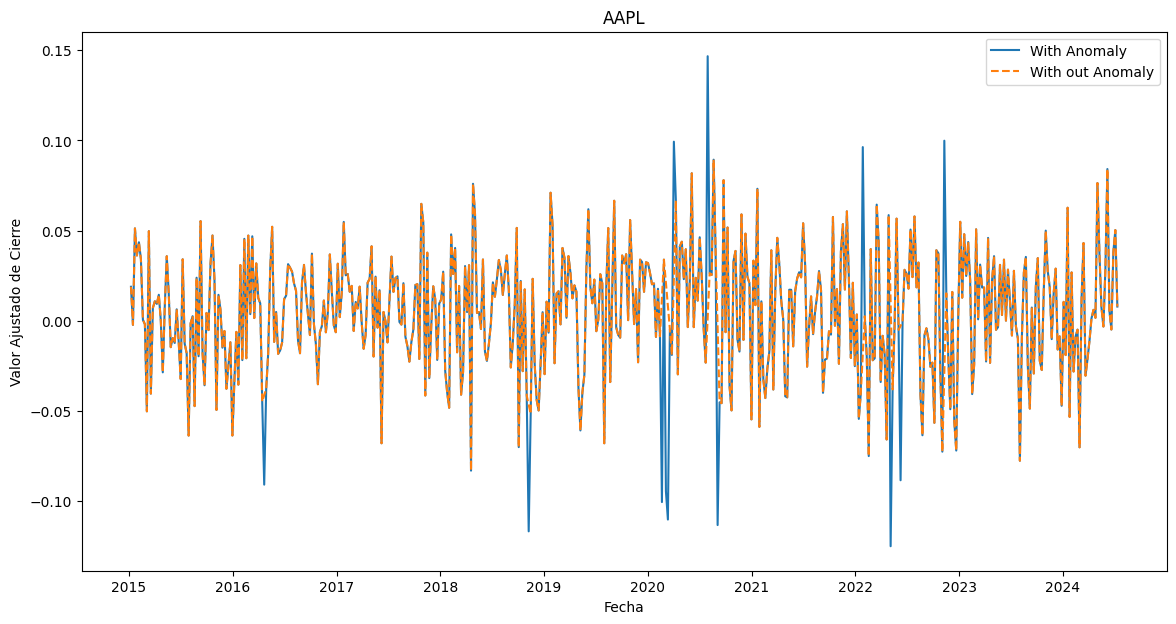

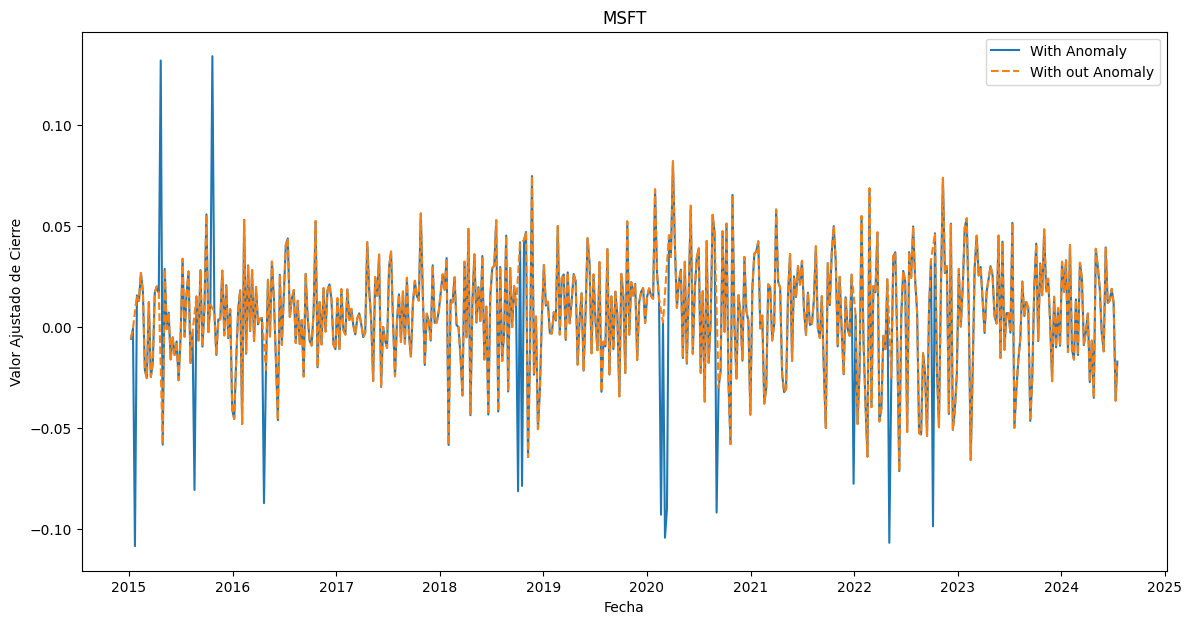

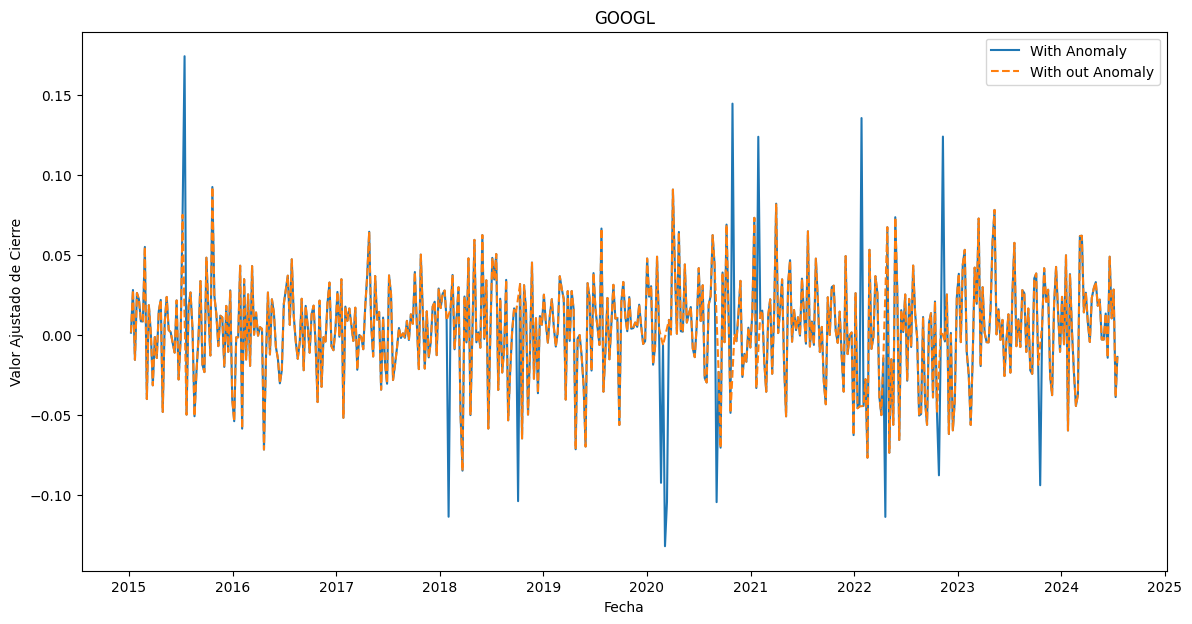

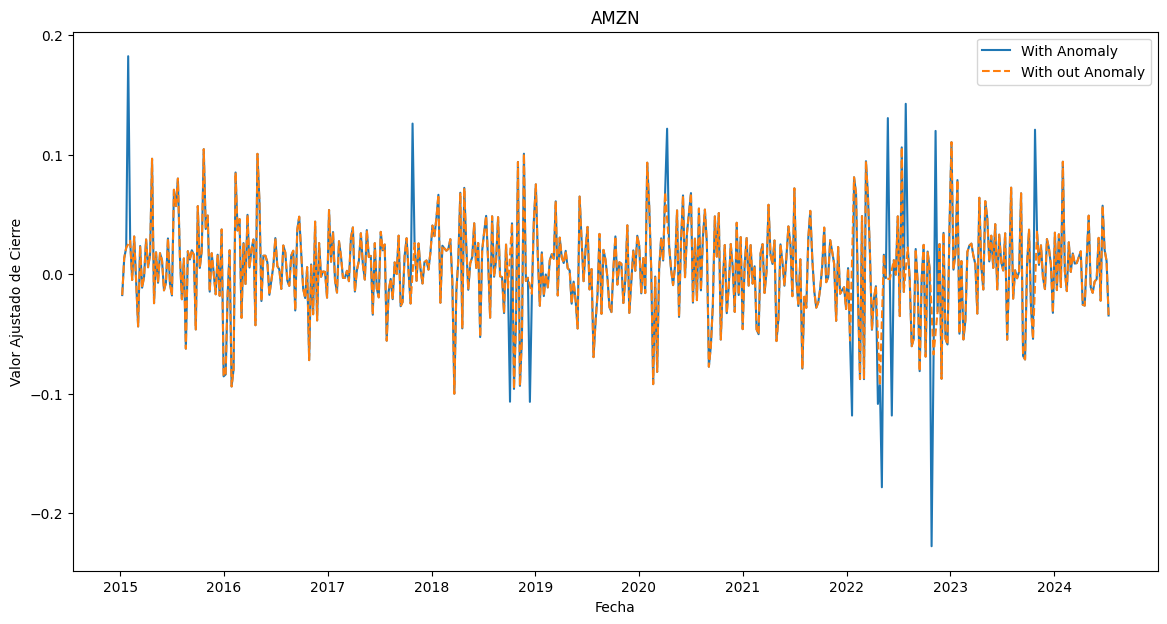

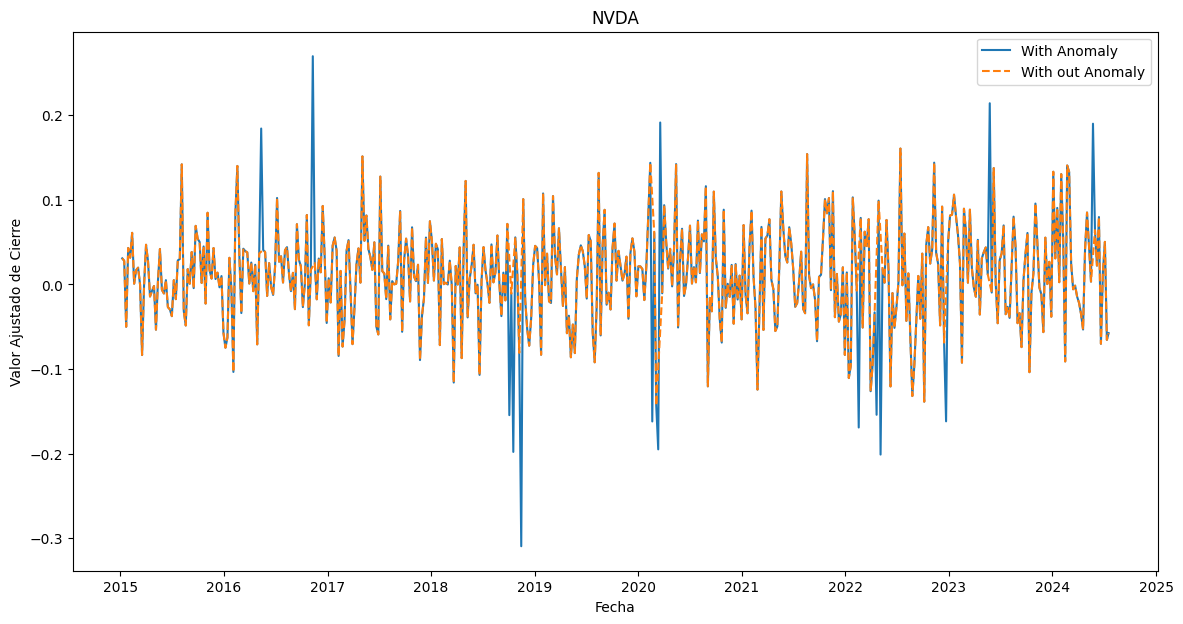

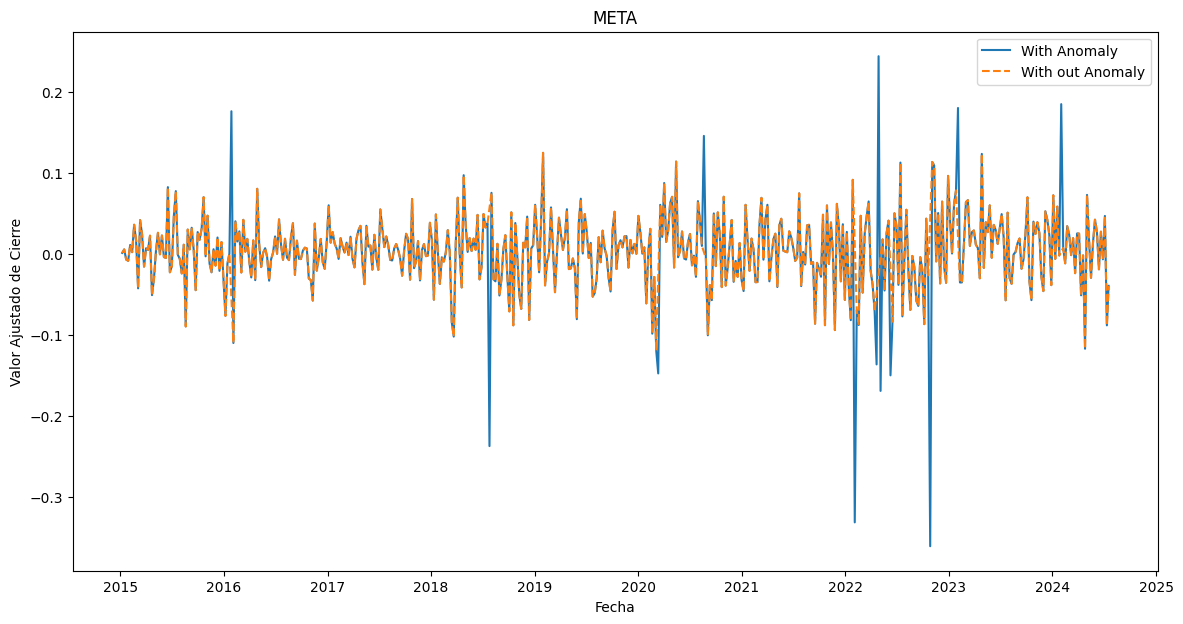

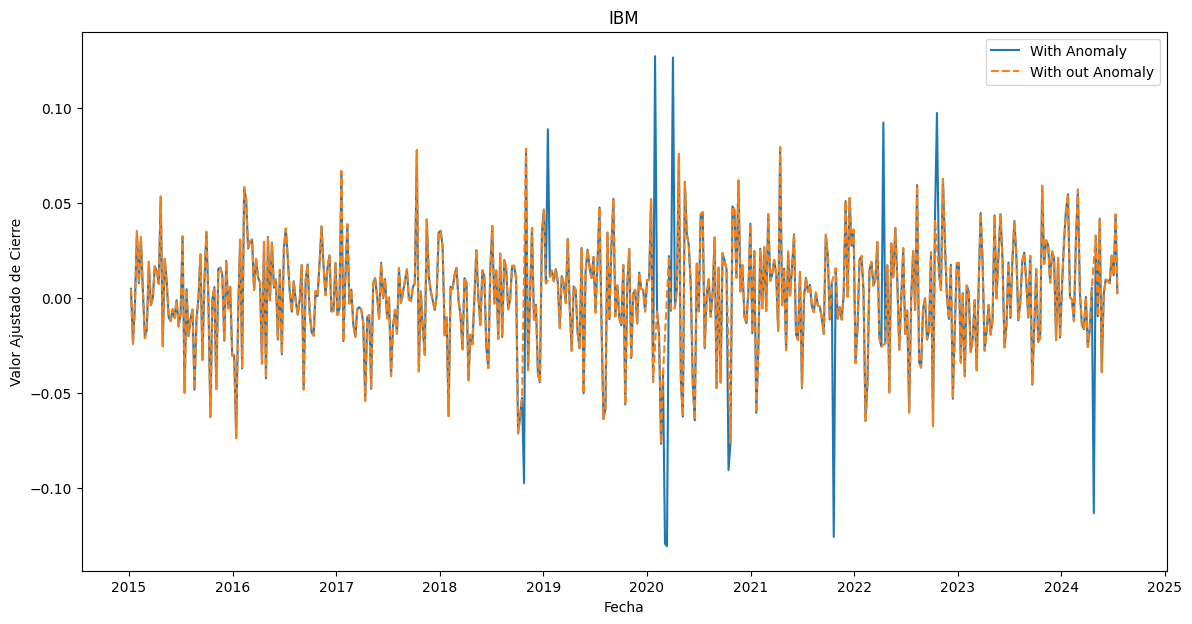

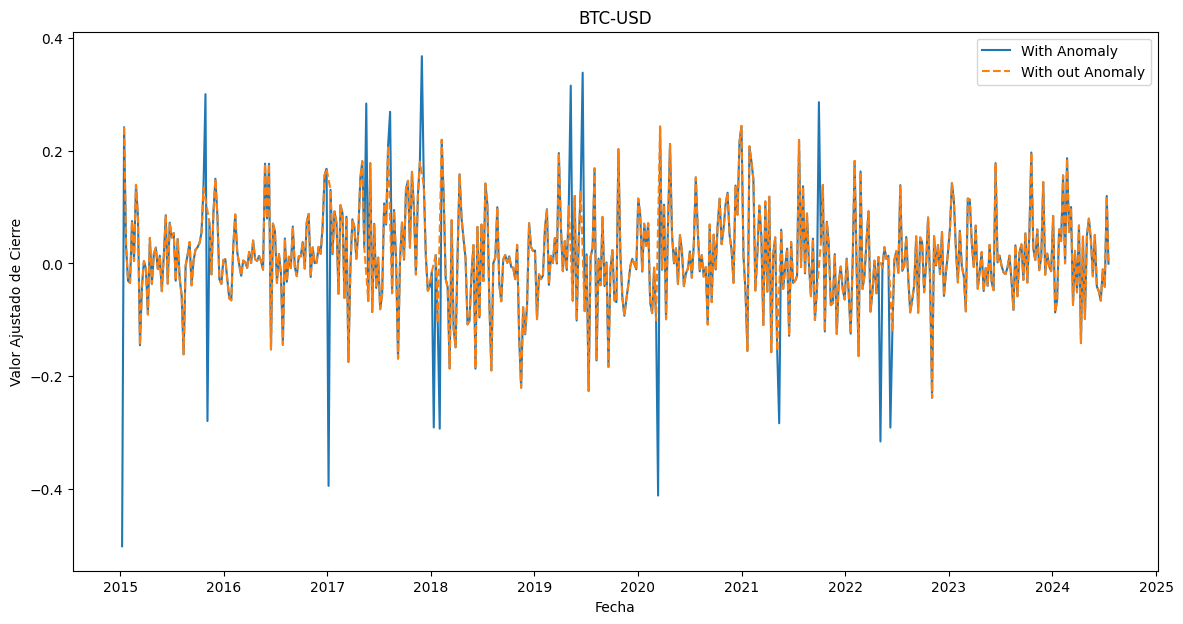

In [11]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()


In [12]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    1
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [13]:
season_length = 52 # Define season length as 52 weeks for monthly data
horizon = 3 # Forecast horizon is set to 3 weeks

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [14]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

ValueError: This function does not handle missing values

In [40]:
cv_df = sf.cross_validation(df=ts_not_anom, h=horizon, n_windows=5, step_size=horizon, level=[95])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,RWD,RWD-lo-90,RWD-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,
AAPL,2023-09-19,2023-09-12,-0.010677,-0.007780,-0.106668,0.091108,0.006575,-0.062498,0.075648,-0.007869,-0.106959,0.091222,-0.024309,-0.130460,0.081842
AAPL,2023-09-26,2023-09-12,-0.013321,-0.007780,-0.147629,0.132069,0.006575,-0.062498,0.075648,-0.007958,-0.148378,0.132463,-0.056764,-0.162915,0.049386
AAPL,2023-10-03,2023-09-12,0.029713,-0.007780,-0.179059,0.163499,0.006575,-0.062498,0.075648,-0.008046,-0.180375,0.164282,-0.014353,-0.120504,0.091797
AAPL,2023-10-10,2023-10-03,-0.001510,0.029713,-0.068677,0.128102,0.006518,-0.062230,0.075267,0.029777,-0.068812,0.128365,0.014072,-0.091525,0.119670
AAPL,2023-10-17,2023-10-03,-0.032529,0.029713,-0.109432,0.168857,0.006518,-0.062230,0.075267,0.029841,-0.109866,0.169547,0.048252,-0.057346,0.153849


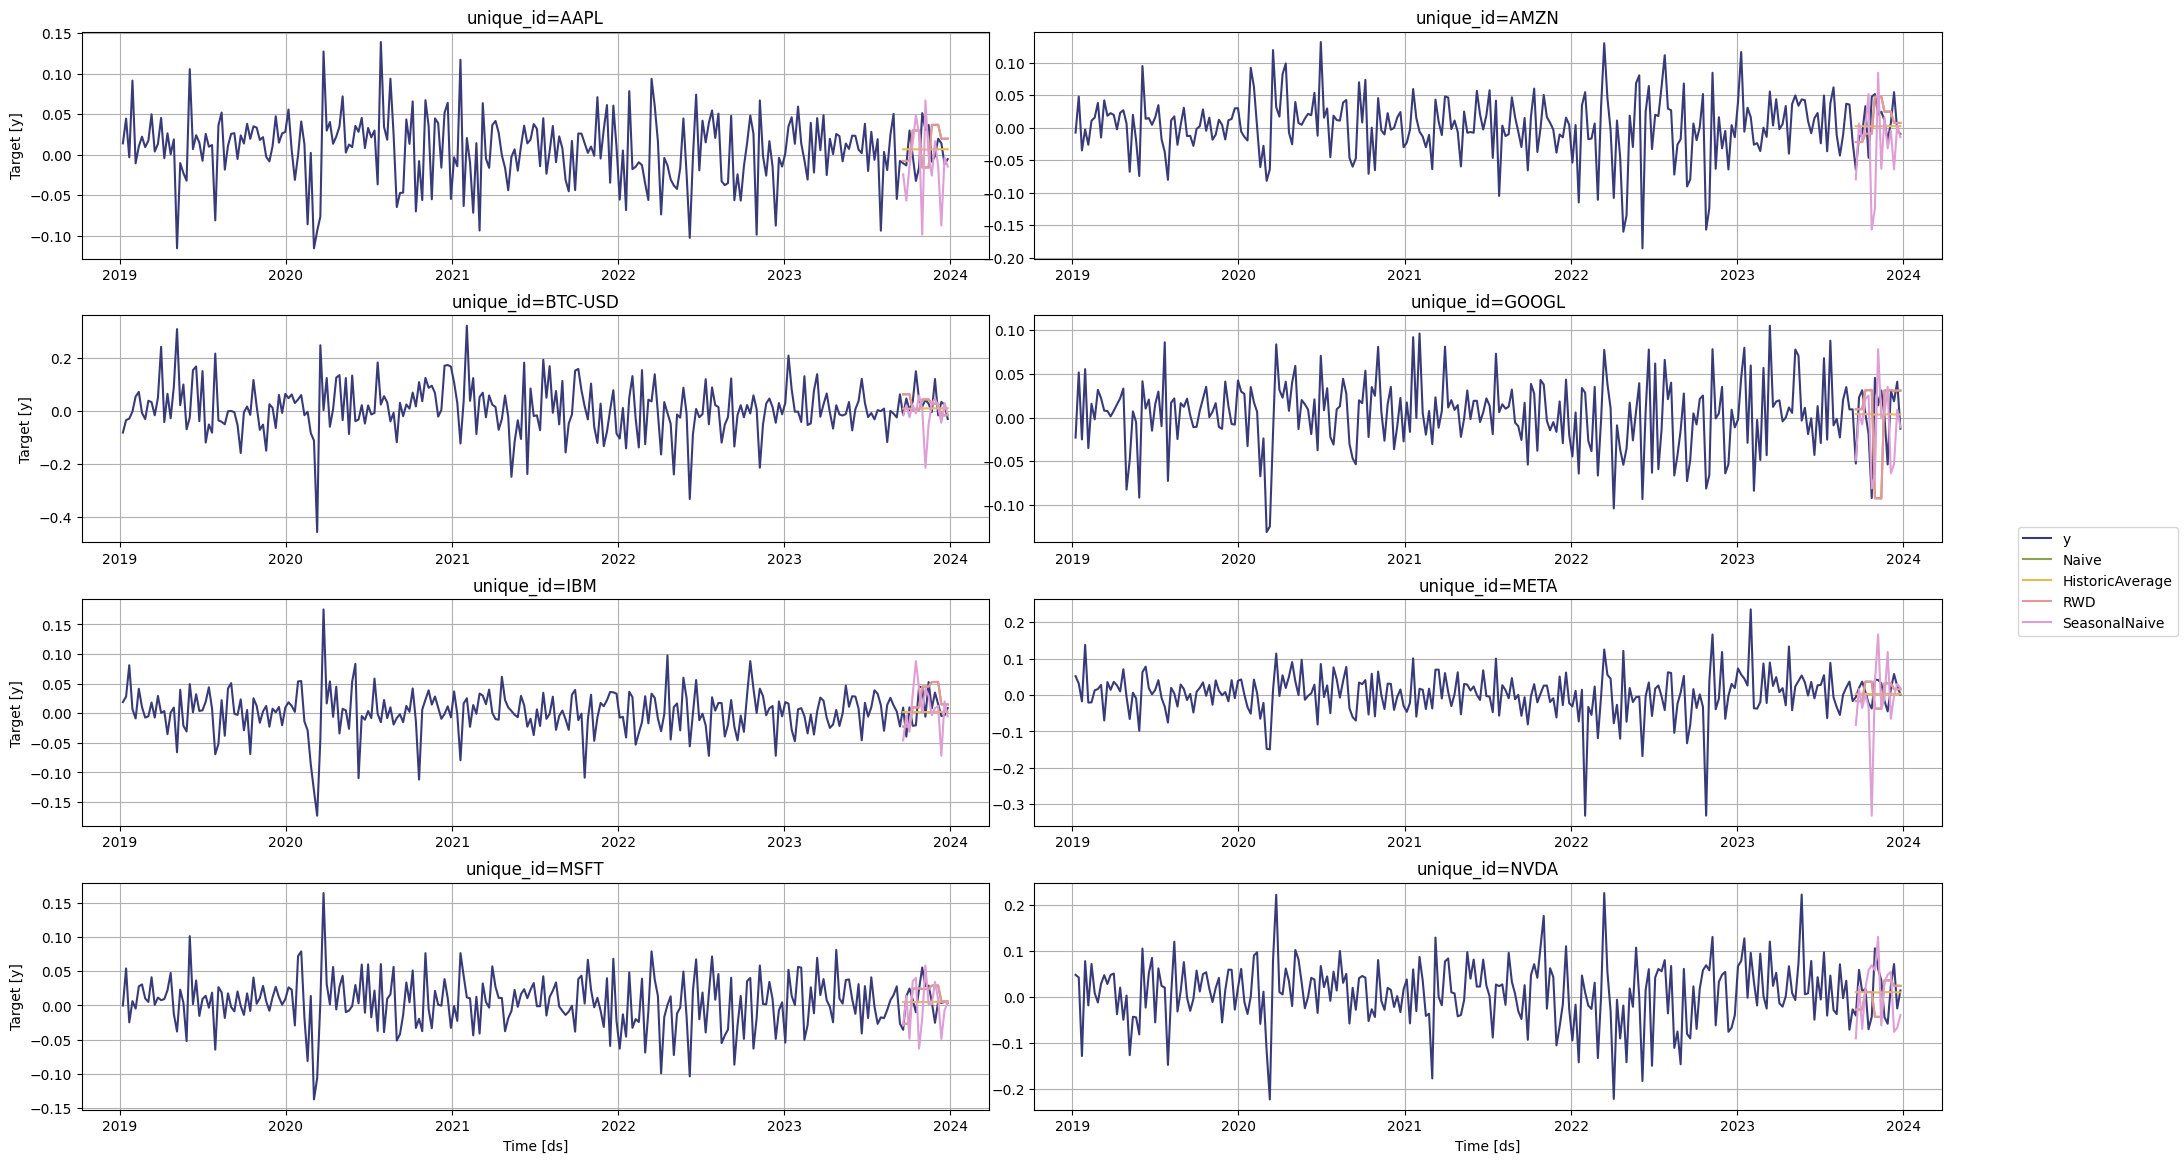

In [42]:
StatsForecast.plot(ts_not_anom, cv_df.drop(['cutoff', 'y'], axis=1))

In [43]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [44]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [45]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [46]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [47]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, mape, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-09 15:22:40,812 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 521d6bc694cbb3de8ea3f4d0e28f7c55 initialized by task ('shuffle-transfer-521d6bc694cbb3de8ea3f4d0e28f7c55', 1) executed on worker tcp://127.0.0.1:57465
2024-07-09 15:22:45,347 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 521d6bc694cbb3de8ea3f4d0e28f7c55 deactivated due to stimulus 'task-finished-1720531365.323494'


,unique_id,cutoff,metric,Naive,HistoricAverage,RWD,SeasonalNaive
0,AAPL,2023-12-05,mse,0.000549,0.000179,0.000551,0.003486
1,AAPL,2023-12-05,mae,0.020726,0.012608,0.020771,0.039547
2,AAPL,2023-12-05,smape,144.609406,157.172104,144.64621,130.622009
3,AMZN,2023-11-14,mse,0.000815,0.000195,0.000828,0.000107
4,AMZN,2023-11-14,mae,0.025071,0.011856,0.025325,0.009808


In [48]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  HistoricAverage         RWD  SeasonalNaive
cutoff     metric                                                        
2023-09-12 mae        0.03247         0.025459    0.032759       0.032957
           mse       0.001577         0.000951    0.001608       0.001699
           smape   130.742767       159.862946  130.454498     118.874039
2023-10-03 mae       0.047672         0.035562    0.047642       0.067137
           mse        0.00332          0.00225    0.003314       0.009579
           smape   168.098526       164.320099  167.658218     144.259171
2023-10-24 mae        0.05374         0.033568    0.054156       0.073531
           mse       0.004885         0.001472    0.004942       0.008588
           smape   126.078117       152.152634  126.301094      149.88739
2023-11-14 mae       0.041217         0.025453    0.041392       0.041463
           mse       0.002406           0.0013    0.002413        0.00343
           smape   143.289429       151.014694  143.429382     141.949066
2023-12-05 mae       0.022066         0.019037    0.022086       0.039758
           mse       0.000767         0.000682    0.000767       0.003159
           smape   122.595673       138.598724  122.833557     139.403076

In [49]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

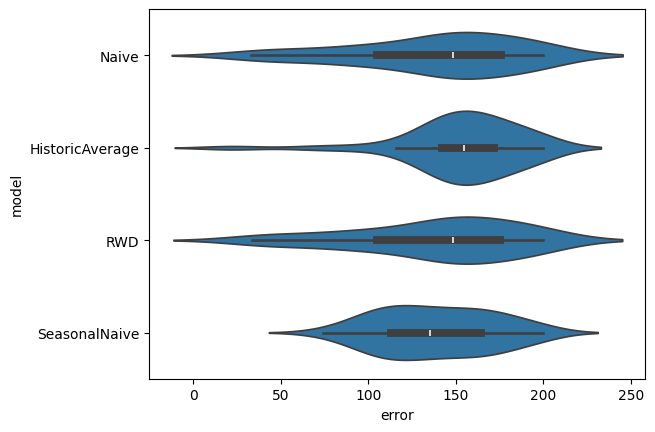

In [50]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

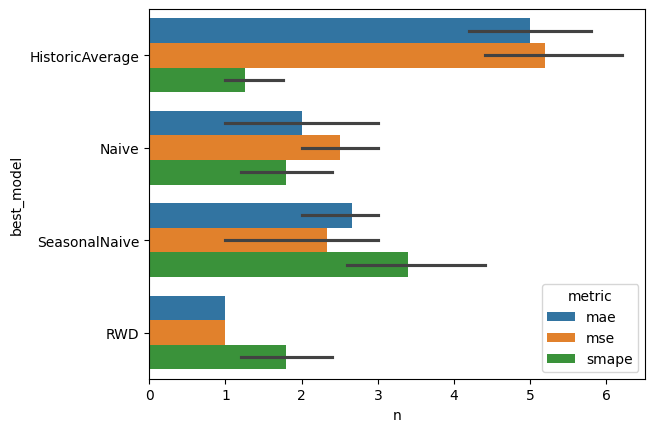

In [51]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')